# 1D coordinate basis

First we include the Gadfly library for plotting. 

Secondly, we set up the coordinate mesh on which we solve the Sch. equation for the harmonic oscillator potential. Here we deal with a simple 1D harmonic oscillator. We choose the Fourier mesh over the interval $\left\langle -N/2, N/2\right\rangle$.

We set number of mesh points and distribute them evenly as
$$x_{j} = j \qquad \text{where} \qquad j = -\frac{1}{2}(N-1), \ldots, \frac{1}{2}(N-1)$$
that is
$$x_{j} = j - 1 - \frac{1}{2}(N-1), \qquad j = 1, \ldots, N$$

This mesh is connected with the Lagrange-Fourier functions
$$f_{j}(x) = \frac{1}{N} \frac{\sin \pi(x - x_{j})}{\sin \frac{\pi}{N} (x - x_{j})}$$

The mesh is scaled with a scaling factor $h = 0.35$ to make it better cover the physically interesting part of space. For 51 mesh points the original mesh covers the interval $[-25, 25]$, whereas the scaled mesh covers the interval $[-8.75, 8.75]$.

The Sch. equation then takes the form
$$\sum_{i = 1}^{N} \left(h^{-2}T_{ij} + V(hx_{i})\delta_{ij}\right)c_{j} = E c_{i},$$
where the wave function is expanded in terms of the Lagrange-Fourier functions
$$\Psi(x) = \sum_{i = 1}^{N} c_{i} f_{i}(x),$$
and $h$ is the scale factor.

In [230]:
using Gadfly
using Colors
using Compose

In [183]:
nmesh = 51; # mesh size
mesh = [1:nmesh] - (nmesh+1)/2;
scale = 0.35;

lambda = 1;
println(mesh)
println(scale*mesh)

evals = 0.5*(2*[1:nmesh] - 1);

[-25.0,-24.0,-23.0,-22.0,-21.0,-20.0,-19.0,-18.0,-17.0,-16.0,-15.0,-14.0,-13.0,-12.0,-11.0,-10.0,-9.0,-8.0,-7.0,-6.0,-5.0,-4.0,-3.0,-2.0,-1.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0]
[-8.75,-8.399999999999999,-8.049999999999999,-7.699999999999999,-7.35,-7.0,-6.6499999999999995,-6.3,-5.949999999999999,-5.6,-5.25,-4.8999999999999995,-4.55,-4.199999999999999,-3.8499999999999996,-3.5,-3.15,-2.8,-2.4499999999999997,-2.0999999999999996,-1.75,-1.4,-1.0499999999999998,-0.7,-0.35,0.0,0.35,0.7,1.0499999999999998,1.4,1.75,2.0999999999999996,2.4499999999999997,2.8,3.15,3.5,3.8499999999999996,4.199999999999999,4.55,4.8999999999999995,5.25,5.6,5.949999999999999,6.3,6.6499999999999995,7.0,7.35,7.699999999999999,8.049999999999999,8.399999999999999,8.75]


The harmonic oscillator potential has the simple form
$$V(x) = \frac{1}{2}m\omega^{2} x^{2}.$$
We choose the natural units where $\hbar = m = \omega = 1$ simplifying the equation numerically. The energies of the system which are normally equal to
$$E_{n} = \left(n + \frac{1}{2}\right)\hbar \omega$$
now become simply
$$E_{n} = n + \frac{1}{2}$$.

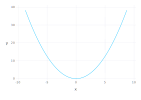

In [207]:
# potential plot
xplot = scale*0.05*([1:1001] - 1002/2);

pot = 0.5*xplot.*xplot;

plot(x = xplot, y = pot, Geom.line, Coord.Cartesian(xmin = -10, xmax = 10))

We define the kinetic and potential matrix elements of the Hamiltonian. In 1D case the kinetic part is simply
$$T = -\frac{d^{2}}{dx^{2}}$$, and the kinetic matrix elements can be obtained in a closed form:
$$T_{ij} = \left\{ \begin{array}{ccc}
\frac{\pi^{2}}{3} \left(1 - \frac{1}{N^{2}}\right) & \text{for} & i = j \\
(-1)^{i-j} \frac{2\pi^{2}}{N^{2}} \frac{\cos \frac{\pi}{N}(x_{i} - x_{j})}{\sin^{2} \frac{\pi}{N}(x_{i} - x_{j})} & \text{for} & i \ne j \end{array} \right.$$

The Lagrange basis is designed in such a way that the potential is diagonal, i.e.
$$V_{ij} = V(x_{i})\delta_{ij}$$.

In [208]:
function kinetic(i, j, mesh)
  n = size(mesh)[1];
  if(i == j)
    pi23 = pi*pi/3.0;
    n1 = 1/(n*n);
    return pi23*(1.0 - n1);
  else
    fac1 = (-1.0)^(i-j);
    fac2 = 2*pi*pi/(n*n);
    facpin = pi/n;
    fac3 = cos(facpin*(mesh[i] - mesh[j]));
    fac4 = sin(facpin*(mesh[i] - mesh[j]));
    return fac1*fac2*fac3/(fac4*fac4);
  end
end

function potential(x)
  return 0.5*x.*x
end

function basis_func_primitive(x, j, mesh)
  nmesh = size(mesh)[1];
  
  fac1 = sin(pi*(x - mesh[j]))
  fac2 = sin(pi*(x - mesh[j])/nmesh)
  
  return fac1/(nmesh*fac2)
end

basis_func_primitive (generic function with 1 method)

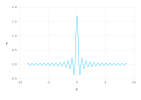

In [209]:
y_basis_plot = zeros(size(xplot)[1]);
for i = 1:size(xplot)[1]
  y_basis_plot[i] = basis_func(xplot[i],26,mesh,0.35);
end

plot(x = xplot, y = y_basis_plot, Geom.line)

In [210]:
function wfun(eigvec, out_mesh, in_mesh, scale)
  nom = size(out_mesh)[1];
  nim = size(in_mesh)[1];
  wf = zeros(nom);
  
  for i = 1:nom
    wf[i] = 0.0;
    for j = 1:nim
      wf[i] = wf[i] + eigvec[j]*basis_func_primitive(out_mesh[i]/scale, j, in_mesh);
    end
  end
  
  return wf/sqrt(scale);
end

wfun (generic function with 2 methods)

The Hamiltonian is constructed as a sum of the kinetic matrix and the diagonal matrix of the potential.

It is then diagonalized, and as a test we check the norm of the first eigenvector. As the exact energies are known we can compare the obtained solutions with the exact ones. The accuracy of the solutions is quite good, with the first 20 eigenenergies being within $10^{-10}$ of the exact value. The wavefunctions of higher energy states significantly explore the potential beyond the mesh and are, therefore, not so well reproduced. 

In [211]:
hamiltonian = zeros(nmesh,nmesh);
for row = 1:nmesh
  for col = 1:nmesh
    hamiltonian[row,col] = 0.5*kinetic(row,col,mesh)/(scale*scale);
  end
end
hamiltonian = hamiltonian + diagm(vec(potential(mesh*scale)));

1.0000000000000002


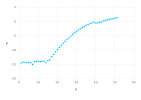

In [212]:
F = eigfact(hamiltonian);
println(sum(F[:vectors][:,3].*F[:vectors][:,3]))

plot(x = [1:nmesh], y = log10(abs(evals - F[:values])), Geom.point)

Finally, we plot the wavefunctions of the first few states. As the solution is a linear combination of wavefunctions it can also be calculated outside the given meshpoints and we do so for 1001 points.

In [245]:
col = convert(RGB{U8}, colorant"deepskyblue");

n = 6
col_array = Colors.distinguishable_colors(n,col,
            lchoices = Float64[65, 70, 75, 80],
            cchoices = Float64[0, 50, 60, 70],
            hchoices = linspace(0, 330, 24));

#dot = 1.5*Compose.cm;
pot_theme = Theme(default_color = col_array[1]);
wf_theme = Theme(default_color = col_array[2]);

In [251]:
fig_wf0 = plot(
  layer(x = xplot, y = F[:values][1] + wfun(F[:vectors][:,1], xplot, mesh, scale), Geom.line, wf_theme),
  layer(x = xplot, y = F[:values][2] + wfun(F[:vectors][:,2], xplot, mesh, scale), Geom.line, wf_theme),
  layer(x = xplot, y = pot, Geom.line, pot_theme), 
  Coord.Cartesian(xmin = -5, xmax = 5, ymin = 0, ymax = 3)
)
display(fig_wf0)

fig_wf1 = plot(
  layer(x = xplot, y = F[:values][3] + wfun(F[:vectors][:,3], xplot, mesh, scale), Geom.line, wf_theme),
  layer(x = xplot, y = F[:values][4] + wfun(F[:vectors][:,4], xplot, mesh, scale), Geom.line, wf_theme),
  layer(x = xplot, y = pot, Geom.line, pot_theme), 
  Coord.Cartesian(xmin = -5, xmax = 5, ymin = 0, ymax = 6)
)
display(fig_wf1)

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 x 
 
 
 -20 
 -15 
 -10 
 -5 
 0 
 5 
 10 
 15 
 20 
 -15.0 
 -14.5 
 -14.0 
 -13.5 
 -13.0 
 -12.5 
 -12.0 
 -11.5 
 -11.0 
 -10.5 
 -10.0 
 -9.5 
 -9.0 
 -8.5 
 -8.0 
 -7.5 
 -7.0 
 -6.5 
 -6.0 
 -5.5 
 -5.0 
 -4.5 
 -4.0 
 -3.5 
 -3.0 
 -2.5 
 -2.0 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 3.0 
 3.5 
 4.0 
 4.5 
 5.0 
 5.5 
 6.0 
 6.5 
 7.0 
 7.5 
 8.0 
 8.5 
 9.0 
 9.5 
 10.0 
 10.5 
 11.0 
 11.5 
 12.0 
 12.5 
 13.0 
 13.5 
 14.0 
 14.5 
 15.0 
 -20 
 -10 
 0 
 10 
 20 
 -15 
 -14 
 -13 
 -12 
 -11 
 -10 
 -9 
 -8 
 -7 
 -6 
 -5 
 -4 
 -3 
 -2 
 -1 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 12 
 13 
 14 
 15 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M-27.75,-836.4 L -27.54 -832.74 -27.34 -829.09 -27.13 -825.45 -26.92 -821.82 -26.72 -818.19 -26.51 -814.57 -26.3 -810.95 -26.1 -807.35 -25.89 -803.75 -25.69 -800.16 -25.48 -796.58 -25.27 -793 -25.07 -789.43 -24.86 -785.87 -24.65 -782.32 -24.45 -778.77 -24.24 -775.23 -24.03 -771.7 -23.83 -768.17 -23.62 -764.65 -23.41 -761.14 -23.21 -757.64 -23 -754.14 -22.8 -750.66 -22.59 -747.17 -22.38 -743.7 -22.18 -740.23 -21.97 -736.78 -21.76 -733.32 -21.56 -729.88 -21.35 -726.44 -21.14 -723.01 -20.94 -719.59 -20.73 -716.17 -20.53 -712.77 -20.32 -709.37 -20.11 -705.97 -19.91 -702.59 -19.7 -699.21 -19.49 -695.84 -19.29 -692.47 -19.08 -689.12 -18.87 -685.77 -18.67 -682.42 -18.46 -679.09 -18.25 -675.76 -18.05 -672.44 -17.84 -669.13 -17.64 -665.82 -17.43 -662.53 -17.22 -659.24 -17.02 -655.95 -16.81 -652.68 -16.6 -649.41 -16.4 -646.15 -16.19 -642.89 -15.98 -639.65 -15.78 -636.41 -15.57 -633.17 -15.37 -629.95 -15.16 -626.73 -14.95 -623.52 -14.75 -620.32 -14.54 -617.12 -14.33 -613.93 -14.13 -610.75 -13.92 -607.58 -13.71 -604.41 -13.51 -601.25 -13.3 -598.1 -13.09 -594.96 -12.89 -591.82 -12.68 -588.69 -12.48 -585.57 -12.27 -582.45 -12.06 -579.35 -11.86 -576.25 -11.65 -573.15 -11.44 -570.07 -11.24 -566.99 -11.03 -563.92 -10.82 -560.85 -10.62 -557.8 -10.41 -554.75 -10.21 -551.71 -10 -548.67 -9.79 -545.64 -9.59 -542.62 -9.38 -539.61 -9.17 -536.61 -8.97 -533.61 -8.76 -530.62 -8.55 -527.64 -8.35 -524.66 -8.14 -521.69 -7.93 -518.73 -7.73 -515.78 -7.52 -512.83 -7.32 -509.89 -7.11 -506.96 -6.9 -504.03 -6.7 -501.12 -6.49 -498.21 -6.28 -495.3 -6.08 -492.41 -5.87 -489.52 -5.66 -486.64 -5.46 -483.76 -5.25 -480.9 -5.05 -478.04 -4.84 -475.19 -4.63 -472.34 -4.43 -469.51 -4.22 -466.68 -4.01 -463.86 -3.81 -461.04 -3.6 -458.23 -3.39 -455.43 -3.19 -452.64 -2.98 -449.85 -2.77 -447.08 -2.57 -444.31 -2.36 -441.54 -2.16 -438.79 -1.95 -436.04 -1.74 -433.29 -1.54 -430.56 -1.33 -427.83 -1.12 -425.11 -0.92 -422.4 -0.71 -419.7 -0.5 -417 -0.3 -414.31 -0.09 -411.62 0.11 -408.95 0.32 -406.28 0.53 -403.62 0.73 -400.97 0.94 -398.32 1.15 -395.68 1.35 -393.05 1.56 -390.42 1.77 -387.81 1.97 -385.2 2.18 -382.59 2.39 -380 2.59 -377.41 2.8 -374.83 3 -372.26 3.21 -369.69 3.42 -367.13 3.62 -364.58 3.83 -362.04 4.04 -359.5 4.24 -356.97 4.45 -354.45 4.66 -351.93 4.86 -349.43 5.07 -346.93 5.27 -344.43 5.48 -341.95 5.69 -339.47 5.89 -337 6.1 -334.54 6.31 -332.08 6.51 -329.63 6.72 -327.19 6.93 -324.75 7.13 -322.33 7.34 -319.91 7.55 -317.5 7.75 -315.09 7.96 -312.69 8.16 -310.3 8.37 -307.92 8.58 -305.54 8.78 -303.18 8.99 -300.82 9.2 -298.46 9.4 -296.12 9.61 -293.78 9.82 -291.44 10.02 -289.12 10.23 -286.8 10.43 -284.49 10.64 -282.19 10.85 -279.9 11.05 -277.61 11.26 -275.33 11.47 -273.05 11.67 -270.79 11.88 -268.53 12.09 -266.28 12.29 -264.04 12.5 -261.8 12.71 -259.5

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 x 
 
 
 -20 
 -15 
 -10 
 -5 
 0 
 5 
 10 
 15 
 20 
 -15.0 
 -14.5 
 -14.0 
 -13.5 
 -13.0 
 -12.5 
 -12.0 
 -11.5 
 -11.0 
 -10.5 
 -10.0 
 -9.5 
 -9.0 
 -8.5 
 -8.0 
 -7.5 
 -7.0 
 -6.5 
 -6.0 
 -5.5 
 -5.0 
 -4.5 
 -4.0 
 -3.5 
 -3.0 
 -2.5 
 -2.0 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 3.0 
 3.5 
 4.0 
 4.5 
 5.0 
 5.5 
 6.0 
 6.5 
 7.0 
 7.5 
 8.0 
 8.5 
 9.0 
 9.5 
 10.0 
 10.5 
 11.0 
 11.5 
 12.0 
 12.5 
 13.0 
 13.5 
 14.0 
 14.5 
 15.0 
 -20 
 -10 
 0 
 10 
 20 
 -15 
 -14 
 -13 
 -12 
 -11 
 -10 
 -9 
 -8 
 -7 
 -6 
 -5 
 -4 
 -3 
 -2 
 -1 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 12 
 13 
 14 
 15 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 <path fill="none" d="M-27.75,-378.84 L -27.54 -377.01 -27.34 -375.19 -27.13 -373.37 -26.92 -371.55 -26.72 -369.74 -26.51 -367.93 -26.3 -366.12 -26.1 -364.32 -25.89 -362.52 -25.69 -360.72 -25.48 -358.93 -25.27 -357.14 -25.07 -355.36 -24.86 -353.58 -24.65 -351.8 -24.45 -350.03 -24.24 -348.26 -24.03 -346.49 -23.83 -344.73 -23.62 -342.97 -23.41 -341.21 -23.21 -339.46 -23 -337.71 -22.8 -335.97 -22.59 -334.23 -22.38 -332.49 -22.18 -330.76 -21.97 -329.03 -21.76 -327.3 -21.56 -325.58 -21.35 -323.86 -21.14 -322.15 -20.94 -320.44 -20.73 -318.73 -20.53 -317.03 -20.32 -315.33 -20.11 -313.63 -19.91 -311.94 -19.7 -310.25 -19.49 -308.56 -19.29 -306.88 -19.08 -305.2 -18.87 -303.53 -18.67 -301.85 -18.46 -300.19 -18.25 -298.52 -18.05 -296.86 -17.84 -295.21 -17.64 -293.55 -17.43 -291.91 -17.22 -290.26 -17.02 -288.62 -16.81 -286.98 -16.6 -285.35 -16.4 -283.72 -16.19 -282.09 -15.98 -280.47 -15.78 -278.85 -15.57 -277.23 -15.37 -275.62 -15.16 -274.01 -14.95 -272.4 -14.75 -270.8 -14.54 -269.2 -14.33 -267.61 -14.13 -266.02 -13.92 -264.43 -13.71 -262.85 -13.51 -261.27 -13.3 -259.69 -13.09 -258.12 -12.89 -256.55 -12.68 -254.99 -12.48 -253.43 -12.27 -251.87 -12.06 -250.32 -11.86 -248.77 -11.65 -247.22 -11.44 -245.68 -11.24 -244.14 -11.03 -242.6 -10.82 -241.07 -10.62 -239.54 -10.41 -238.02 -10.21 -236.5 -10 -234.98 -9.79 -233.46 -9.59 -231.95 -9.38 -230.45 -9.17 -228.95 -8.97 -227.45 -8.76 -225.95 -8.55 -224.46 -8.35 -222.97 -8.14 -221.49 -7.93 -220.01 -7.73 -218.53 -7.52 -217.06 -7.32 -215.59 -7.11 -214.12 -6.9 -212.66 -6.7 -211.2 -6.49 -209.75 -6.28 -208.29 -6.08 -206.85 -5.87 -205.4 -5.66 -203.96 -5.46 -202.52 -5.25 -201.09 -5.05 -199.66 -4.84 -198.24 -4.63 -196.81 -4.43 -195.4 -4.22 -193.98 -4.01 -192.57 -3.81 -191.16 -3.6 -189.76 -3.39 -188.36 -3.19 -186.96 -2.98 -185.57 -2.77 -184.18 -2.57 -182.8 -2.36 -181.41 -2.16 -180.04 -1.95 -178.66 -1.74 -177.29 -1.54 -175.92 -1.33 -174.56 -1.12 -173.2 -0.92 -171.84 -0.71 -170.49 -0.5 -169.14 -0.3 -167.8 -0.09 -166.45 0.11 -165.12 0.32 -163.78 0.53 -162.45 0.73 -161.13 0.94 -159.8 1.15 -158.48 1.35 -157.17 1.56 -155.85 1.77 -154.55 1.97 -153.24 2.18 -151.94 2.39 -150.64 2.59 -149.35 2.8 -148.06 3 -146.77 3.21 -145.49 3.42 -144.21 3.62 -142.93 3.83 -141.66 4.04 -140.39 4.24 -139.13 4.45 -137.87 4.66 -136.61 4.86 -135.36 5.07 -134.11 5.27 -132.86 5.48 -131.62 5.69 -130.38 5.89 -129.14 6.1 -127.91 6.31 -126.68 6.51 -125.46 6.72 -124.24 6.93 -123.02 7.13 -121.81 7.34 -120.6 7.55 -119.39 7.75 -118.19 7.96 -116.99 8.16 -115.79 8.37 -114.6 8.58 -113.41 8.78 -112.23 8.99 -111.05 9.2 -109.87 9.4 -108.7 9.61 -107.53 9.82 -106.36 10.02 -105.2 10.23 -104.04 10.43 -102.89 10.64 -101.74 10.85 -100.59 11.05 -99.45 11.26 -98.31 11.47 -97.17 11.67 -96.04 11.88 -94.91 12.09 -93.78 12.29 -92.66 12.5 -91.54 12.71 -90.4